### **Spaceship Titanic Dataset exploration & machine learning modeling**
*`Data Science Student Club recruitment task`*

##### 0. Importing basic libraries

In [3]:
%matplotlib inline

import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### 1. Data exploration

In [4]:
# loading dataset into DataFrame object
df = pd.read_csv('dane.csv')

# splitting group_id & passenger_id info into separate columns, mapping to ints, dropping PassengerId column,
# as it is redundant right now.
new_cols = ['GroupId', 'PassengerIdInGroup']
df[new_cols] = df['PassengerId'].str.split('_', expand=True)
df['GroupId'] = df['GroupId'].apply(lambda x: int(x))
df['PassengerIdInGroup'] = df['PassengerIdInGroup'].apply(lambda x: int(x))
df = df.drop('PassengerId', axis=1)
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerIdInGroup
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,1
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,1


In [5]:
# let's split Cabin data into three separate columns.
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
cols = new_cols + 'HomePlanet,CryoSleep,Deck,Num,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported'.split(',')
df = df[cols]

# since Cabin data had missing values, Num column has nan too.
def obj_to_float_missno(x):
    if x is np.nan: return x
    return int(x)
df['Num'] = df['Num'].apply(obj_to_float_missno)

In [6]:
# boolean -> {0, 1}

df['Transported'] = df['Transported'].apply(lambda x: 1 if x else 0)
df['CryoSleep'].isna().sum() #217
df['VIP'].isna().sum() # 203

# since CryoSleep, VIP col has missing values
def bool_to_01_missno(x):
    if x is not np.nan:
        return int(x)
    else: return x
df['CryoSleep'] = df['CryoSleep'].apply(bool_to_01_missno)
df['VIP'] = df['VIP'].apply(bool_to_01_missno)

In [7]:
df.head()

,GroupId,PassengerIdInGroup,HomePlanet,CryoSleep,Deck,Num,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,1,1,Europa,0.0,B,0.0,P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,2,1,Earth,0.0,F,0.0,S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,3,1,Europa,0.0,A,0.0,S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,3,2,Europa,0.0,A,0.0,S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,4,1,Earth,0.0,F,1.0,S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [8]:
# data types in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GroupId             8693 non-null   int64  
 1   PassengerIdInGroup  8693 non-null   int64  
 2   HomePlanet          8492 non-null   object 
 3   CryoSleep           8476 non-null   float64
 4   Deck                8494 non-null   object 
 5   Num                 8494 non-null   float64
 6   Side                8494 non-null   object 
 7   Destination         8511 non-null   object 
 8   Age                 8514 non-null   float64
 9   VIP                 8490 non-null   float64
 10  RoomService         8512 non-null   float64
 11  FoodCourt           8510 non-null   float64
 12  ShoppingMall        8485 non-null   float64
 13  Spa                 8510 non-null   float64
 14  VRDeck              8505 non-null   float64
 15  Name                8493 non-null   object 
 16  Transp

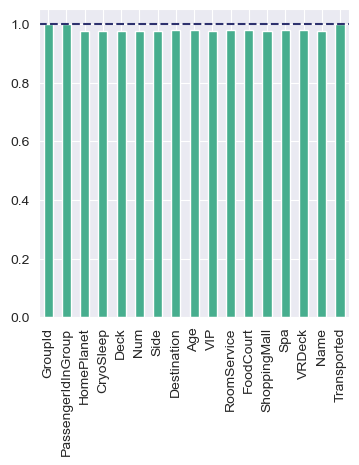

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
(1-df.isna().mean()).abs().plot.bar(ax=ax, color='#47AE8E')
ax.axhline(y=1.0, linestyle='--', color='#2D316E')

<Axes: xlabel='Age', ylabel='Count'>

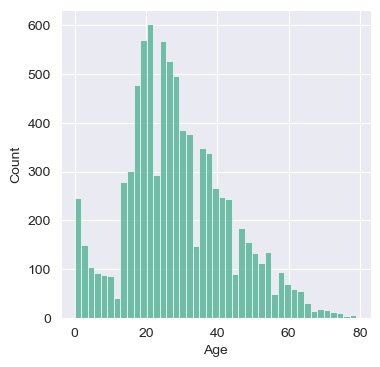

In [10]:
# as we can see, nan values are present in almost every column;
# but in this case, because of the nan values / all values ratio which is near 0, we can ignore them in analysis
# later on, we will impute nan values and see how model performs.

# firstly, let's see passenger's age distribution
sub_df = df['Age']
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(sub_df, color='#47AE8E')

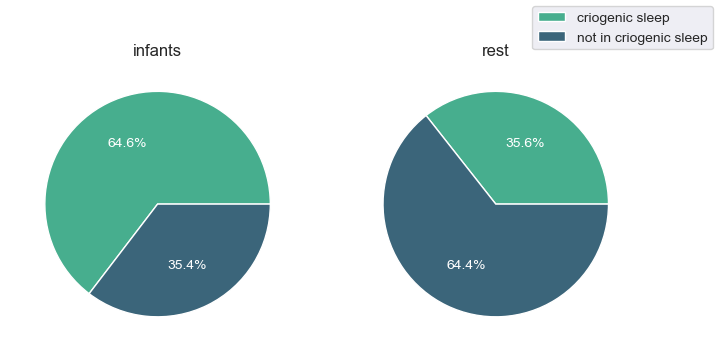

In [11]:
# as we can see, most passengers are in their twenties - thirties
# also, which is suprising, a lot of infants are present!
# let's find out about them little more
mask = df['Age'] == 1
infants_df = df[mask]
infants_cryo = infants_df['CryoSleep'].value_counts()
rest_cryo = df[~mask]['CryoSleep'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
labels = ['criogenic sleep', 'not in criogenic sleep']
ax1.pie(infants_cryo, labels=labels, autopct='%1.1f%%', colors=['#47AE8E', '#3B657A'], textprops={'color':"w"})
ax2.pie(rest_cryo[::-1], autopct='%1.1f%%', colors=['#47AE8E', '#3B657A'], textprops={'color':"w"})

ax2.set_title('rest', fontsize=12)
ax1.set_title('infants', fontsize=12)
fig.legend()
plt.show()

In [12]:
# what is more suprising, statistically ~2/3 infants are in cryogenic sleep
# which is a total opposite for the rest of passengers

# let's see for example how does VIP status affect on expanses
# let's find total of expanses
df['Expanses'] = df['RoomService,FoodCourt,ShoppingMall,Spa,VRDeck'.split(',')].sum(axis=1)
subdf_vips = df.loc[:, ['VIP', 'Expanses']]
subdf_vips.groupby('VIP').agg('mean').reset_index()

,VIP,Expanses
0,0.0,1371.504644
1,1.0,4425.477387


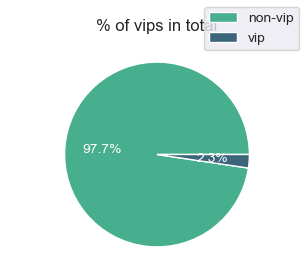

In [13]:
# vips ON AVERAGE spend almost x4 more money on services, which is understandable...

fig, ax = plt.subplots(figsize=(3, 3))
ax.pie(subdf_vips['VIP'].value_counts(), labels=['non-vip', 'vip'], autopct='%1.1f%%', textprops={'color':"w"}, colors=['#47AE8E', '#3B657A'])
ax.set_title('% of vips in total')
fig.legend()

# as we can see, vips are only a small % of all passengers, so we need to be carefull with above reasoning
# it's only ON AVARAGE based on small number of vip records (imbalanced records)

<Axes: xlabel='Age', ylabel='Expanses'>

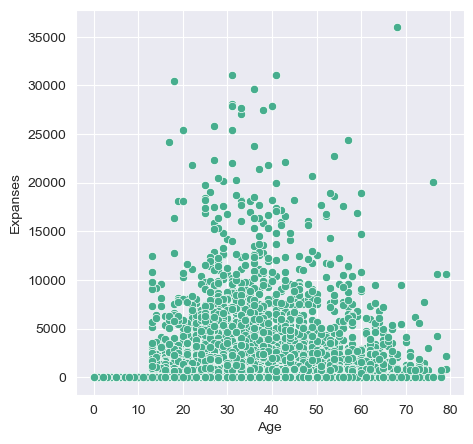

In [14]:
# let's do a quick analysys about relation between ppl age and their expanses

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=df, x='Age', y='Expanses', c='#47AE8E')

In [15]:
# it seems logical that kids under 12-13 are not spending money on services.
# we can also conclude some kind of trend: if you're older, you spend less. (of course some outliers are present as always)

# now we can take care of age distribution for each planet based on passangers

df.groupby('HomePlanet')['Age'].describe()

# there are no countries without infants - that's a relief...
# but what's more, on avarage the eldest community comes from Europa.

,count,mean,std,min,25%,50%,75%,max
HomePlanet,,,,,,,,
Earth,4514.0,26.068232,14.317496,0.0,18.0,23.0,35.0,79.0
Europa,2085.0,34.419664,13.089347,0.0,26.0,33.0,43.0,79.0
Mars,1716.0,29.297203,14.558386,0.0,20.0,28.0,38.0,76.0


<Axes: xlabel='CryoSleep', ylabel='count'>

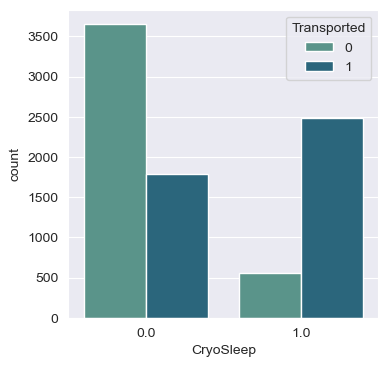

In [16]:
# let's see how being in cryosleep affects being transported.

df_cryo = df[['CryoSleep', 'Transported']]
fig, ax = plt.subplots(figsize=(4, 4))
df_cryo = df_cryo.value_counts().reset_index()
sns.barplot(df_cryo, x='CryoSleep', y='count', hue='Transported', palette='crest')

In [17]:
# suprisingly, majority of passengers that were not in cryosleep were not transported.
# also, a big majority of passengers that were in cryoslepp were transported.
# it seems that being in a cryosleep helps with being transported a lot.

# what about cryosleep-ers expanses?
df_cryo = df[['CryoSleep', 'Expanses']]
df_cryo[df_cryo['CryoSleep'] == 1.0]['Expanses'].sum()


0.0

In [18]:
# sounds about right

# now we will try to predict passenger's gender, in order to gain interesting new results
# firstly, we need to gain data about names

import nltk
import random
from sklearn import model_selection

#nltk.download() # download names

from nltk.corpus import names

last_letter = lambda x: {'last_letter':x[-1]}

data = [(n, '0') for n in names.words('male.txt')] + [(n, '1') for n in names.words('female.txt')]
random.shuffle(data)

featuresets = [(last_letter(n), gender) for (n, gender) in data]

n_bayes_model = nltk.NaiveBayesClassifier

# let's perform cross_validation
k_folds = 10
subset_len = len(featuresets) // k_folds
acc = 0
for i in range(k_folds):
    train_data = featuresets[i*subset_len:][:subset_len]
    test_data = featuresets[:i*subset_len] + featuresets[(i+1)*subset_len:]
    n_bayes_model = n_bayes_model.train(train_data)
    acc += nltk.classify.accuracy(n_bayes_model, test_data)

acc / k_folds

0.7547412587412586

In [19]:
# ~75% is sufficient for our needs
# let's predict gender based on passenger's names

# we have 200 nan values in names, for our needs we can drop those records
df = df[~df['Name'].isna()].reset_index()

df_names = df['Name'].to_list()
df_names = [re.search('([^\s]+)', x).group(0) for x in df_names]

predictions = []
for x in df_names:
    predictions.append(n_bayes_model.classify(last_letter(x)))

df['Gender'] = pd.DataFrame(predictions)
df['Gender'] = df['Gender'].apply(lambda x: int(x))
df = df.drop('index', axis=1)
df.head()

,GroupId,PassengerIdInGroup,HomePlanet,CryoSleep,Deck,Num,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expanses,Gender
0,1,1,Europa,0.0,B,0.0,P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0.0,0
1,2,1,Earth,0.0,F,0.0,S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,736.0,1
2,3,1,Europa,0.0,A,0.0,S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,10383.0,0
3,3,2,Europa,0.0,A,0.0,S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,5176.0,0
4,4,1,Earth,0.0,F,1.0,S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1091.0,1


<Axes: xlabel='Gender', ylabel='CryoSleep'>

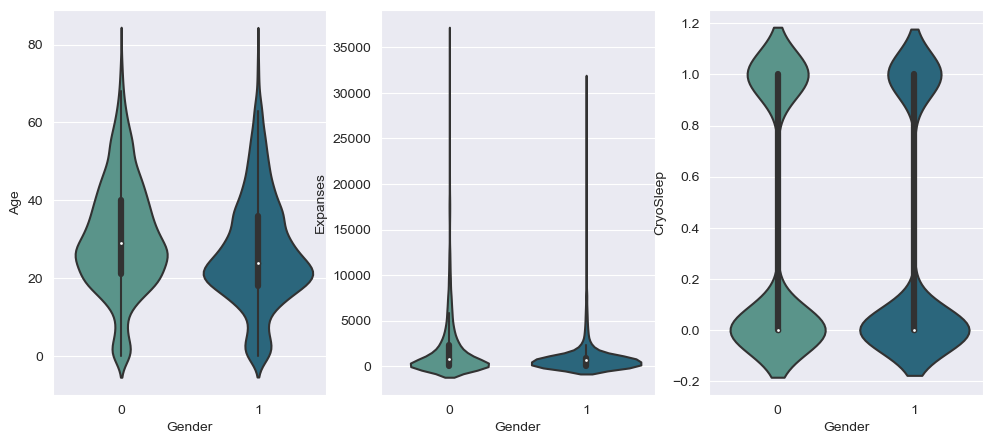

In [20]:
# now we can push further our analysis
# note that 0 means male, 1 means female

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
sns.violinplot(x='Gender', y='Age', data=df, ax=ax[0], palette='crest')
sns.violinplot(x='Gender', y='Expanses', data=df, ax=ax[1], palette='crest')
sns.violinplot(x='Gender', y='CryoSleep', data=df, ax=ax[2], palette='crest')

<Axes: xlabel='Age', ylabel='Expanses'>

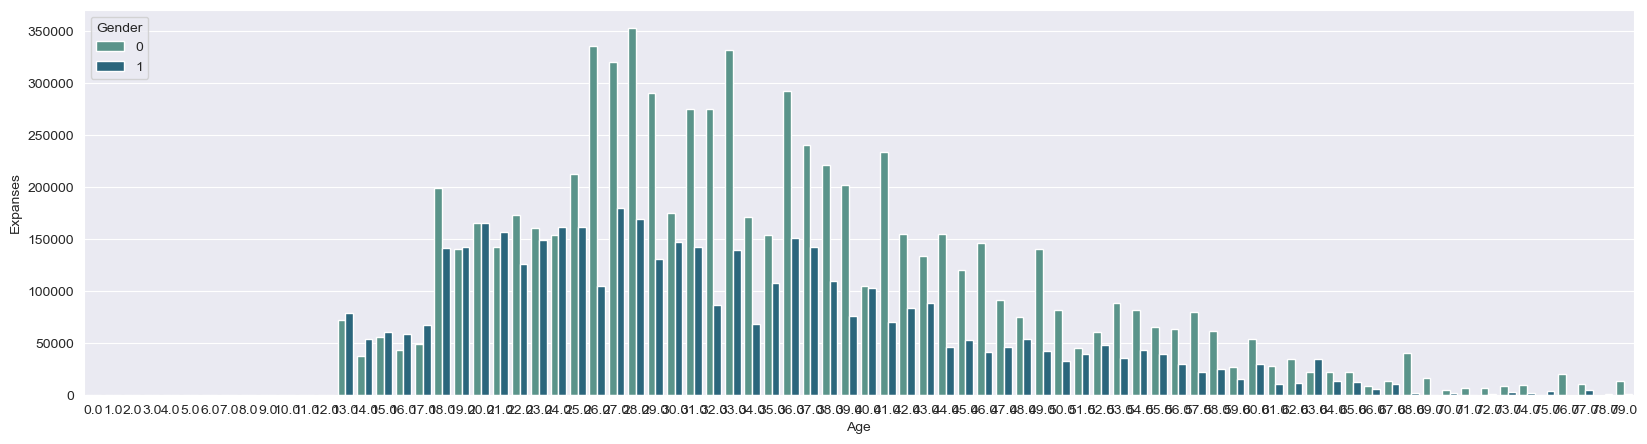

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
df1 = df.groupby(['Gender', 'Age'])['Expanses'].sum().reset_index()

sns.barplot(data=df1, x='Age', y='Expanses', hue='Gender', palette='crest')

<Axes: xlabel='Group_Count', ylabel='Gender'>

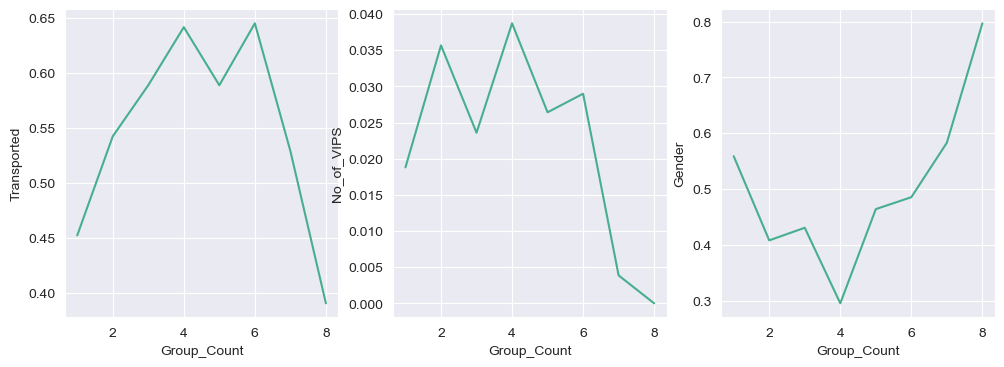

In [22]:
# distributions are practically the same in both genders
# we can add that there are slightly more women than men in their twenties.
# we can observe that suprisingly men are spending more money on additional services than women

# let's see if there are any patterns in groups

grouped_df = df.groupby('GroupId')[['CryoSleep', 'Age', 'VIP', 'Expanses', 'Gender', 'Transported']].agg('mean')
grouped_df['Count'] = df.groupby('GroupId')['PassengerIdInGroup'].count()

vip_groups = pd.DataFrame({'Group_Count': [], 'No_of_VIPS': [], 'Transported': [], 'Gender': []})
group_c = []
no_v = []
transp = []
gend = []
for i in range(1, 9):
    group_c.append(i)
    no_v.append(grouped_df[grouped_df['Count'] == i]['VIP'].mean())
    transp.append(grouped_df[grouped_df['Count'] == i]['Transported'].mean())
    gend.append(grouped_df[grouped_df['Count'] == i]['Gender'].mean())
vip_groups['Group_Count'] = group_c
vip_groups['No_of_VIPS'] = no_v
vip_groups['Transported'] = transp
vip_groups['Gender'] = gend


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data=vip_groups, x='Group_Count', y='Transported', ax=ax[0], color='#47AE8E')
sns.lineplot(data=vip_groups, x='Group_Count', y='No_of_VIPS', ax=ax[1], color='#47AE8E')
sns.lineplot(data=vip_groups, x='Group_Count', y='Gender', ax=ax[2], color='#47AE8E')

In [23]:
# we can say with some probability that 4 or 6 is the best number of ppl in group in case of being transported
# also > 6 ppl in group is too much and transported ratio is going down rapidly

# VIPS prefer to be in smaller groups rather than in bigger ones
# (number of vips is really small, so we need to be careful with that statement)

# statistically speaking, females tend to group in > 6

In [24]:
# now, let's take a closer look at routes.

df_cp = df

def combine(row):
    return str(row['HomePlanet']) + ' => ' + str(row['Destination'])

df_cp['Route'] = df_cp.apply(combine, axis=1)
df_cp = df_cp.drop(['PassengerIdInGroup', 'Deck', 'Num', 'Side', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'], axis=1)
display(df_cp.head())

# we will ignore nan values for now
df_m = df_cp[df_cp['Gender'] == 0]['Route'].value_counts().reset_index()
df_w = df_cp[df_cp['Gender'] == 1]['Route'].value_counts().reset_index()
df_vips = df_cp[df_cp['VIP'] == 1]['Route'].value_counts().reset_index()
df_nvips = df_cp[df_cp['VIP'] == 0]['Route'].value_counts().reset_index()

df_g = pd.merge(left=df_m, right=df_w, on='Route', how='outer').fillna(0)
df_v = pd.merge(df_vips, df_nvips, on='Route', how='outer').fillna(0)
df_fin = pd.merge(df_g, df_v, on='Route', how='outer')
df_fin.columns = ['Route', 'Male', 'Female', 'VIP', 'No-VIP']
display(df_fin)

,GroupId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Expanses,Gender,Route
0,1,Europa,0.0,TRAPPIST-1e,39.0,0.0,0,0.0,0,Europa => TRAPPIST-1e
1,2,Earth,0.0,TRAPPIST-1e,24.0,0.0,1,736.0,1,Earth => TRAPPIST-1e
2,3,Europa,0.0,TRAPPIST-1e,58.0,1.0,0,10383.0,0,Europa => TRAPPIST-1e
3,3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0,5176.0,0,Europa => TRAPPIST-1e
4,4,Earth,0.0,TRAPPIST-1e,16.0,0.0,1,1091.0,1,Earth => TRAPPIST-1e


,Route,Male,Female,VIP,No-VIP
0,Mars => TRAPPIST-1e,1241,202,54.0,1352
1,Europa => TRAPPIST-1e,880,280,54.0,1080
2,Earth => TRAPPIST-1e,702,2330,0.0,2962
3,Europa => 55 Cancri e,701,168,63.0,790
4,Mars => 55 Cancri e,166,20,0.0,182
5,Earth => PSO J318.5-22,156,539,0.0,676
6,Earth => 55 Cancri e,148,524,0.0,650
7,nan => TRAPPIST-1e,75,69,3.0,141
8,Mars => PSO J318.5-22,46,3,8.0,39
9,Mars => nan,34,6,0.0,40


In [25]:
# for male, the most popular was Mars => TRAPPIST-1e route
# for female, the most popular was Earth => TRAPPIST-1e	route

# vips are present in much less routes than it's available
# some routes don't have vip option?

##### 2. Data cleaning & preparation

In [26]:
# for normalizing data
from sklearn.preprocessing import StandardScaler

# for imputing data
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute

In [27]:
df.head()

,GroupId,PassengerIdInGroup,HomePlanet,CryoSleep,Deck,Num,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expanses,Gender,Route
0,1,1,Europa,0.0,B,0.0,P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0.0,0,Europa => TRAPPIST-1e
1,2,1,Earth,0.0,F,0.0,S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,736.0,1,Earth => TRAPPIST-1e
2,3,1,Europa,0.0,A,0.0,S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,10383.0,0,Europa => TRAPPIST-1e
3,3,2,Europa,0.0,A,0.0,S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,5176.0,0,Europa => TRAPPIST-1e
4,4,1,Earth,0.0,F,1.0,S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1091.0,1,Earth => TRAPPIST-1e


In [28]:
# removing features that don't provide any valuable info
cols_to_remove = ['PassengerIdInGroup', 'Name', 'Route']
df_cleaned = df.drop(cols_to_remove, axis=1)

df_cleaned.isna().sum()

GroupId           0
HomePlanet      194
CryoSleep       207
Deck            197
Num             197
Side            197
Destination     178
Age             176
VIP             202
RoomService     180
FoodCourt       178
ShoppingMall    204
Spa             177
VRDeck          184
Transported       0
Expanses          0
Gender            0
dtype: int64

In [29]:
# as we can see, we have a lot of nan values in majority of features
# so we must deal with them, for example by imputing them

cols = ['CryoSleep', 'VIP', 'HomePlanet', 'Deck', 'Side', 'Destination']
to_impute_cols = df_cleaned[cols].mode().to_numpy().tolist()[0]
for i in range(0, len(cols)):
    df_cleaned[cols[i]] = df_cleaned[cols[i]].fillna(to_impute_cols[i])

In [30]:
df_dummy = df_cleaned

# creating dummy columns
dummies = pd.get_dummies(df_cleaned['HomePlanet'], drop_first=True).astype('int')
df_dummy = df_dummy.drop('HomePlanet', axis=1)
df_dummy = pd.concat([df_dummy, dummies], axis=1)

dummies = pd.get_dummies(df_cleaned['Deck']).astype('int')
df_dummy = df_dummy.drop('Deck', axis=1)
df_dummy = pd.concat([df_dummy, dummies], axis=1) 

dummies = pd.get_dummies(df_cleaned['Side'], drop_first=True).astype('int')
df_dummy = df_dummy.drop('Side', axis=1)
df_dummy = pd.concat([df_dummy, dummies], axis=1)

dummies = pd.get_dummies(df_cleaned['Destination'], drop_first=True).astype('int')
df_dummy = df_dummy.drop('Destination', axis=1)
df_dummy = pd.concat([df_dummy, dummies], axis=1)

In [31]:
# remember when we said that travelling alone or with > 6 ppl in group decreases the chances for transport?
# let's add that information to data

df_dummy = pd.merge(df_dummy, grouped_df['Count'], on='GroupId', how='inner')
df_dummy['high&low_group_n'] = df_dummy['Count'].apply(lambda x: 1 if x<=2 or x>6 else 0)
df_dummy = df_dummy.drop('Count', axis=1)

In [32]:
corr_mat = df_dummy.corr()
corr_mat.style.background_gradient(cmap='crest')

,GroupId,CryoSleep,Num,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Expanses,Gender,Europa,Mars,A,B,C,D,E,F,G,T,S,PSO J318.5-22,TRAPPIST-1e,high&low_group_n
GroupId,1.000000,-0.008250,0.681191,-0.011779,0.012640,0.001225,-0.009161,0.011408,-0.005000,0.014254,0.018911,0.001575,-0.005700,0.002026,-0.006766,0.009032,-0.009252,0.011540,-0.008746,-0.002259,0.000795,0.001094,-0.014679,-0.010636,0.015199,-0.008071,-0.008175
CryoSleep,-0.008250,1.000000,-0.037932,-0.075797,-0.078336,-0.246832,-0.207986,-0.226860,-0.200196,-0.198554,0.461459,-0.378688,-0.062753,0.094995,0.030846,-0.028122,0.122331,0.030093,-0.068073,-0.111602,-0.208478,0.240921,-0.015939,0.023403,0.085617,-0.112537,-0.067751
Num,0.681191,-0.037932,1.000000,-0.132236,-0.099465,-0.009837,-0.182388,0.003939,-0.130234,-0.140614,-0.047268,-0.213453,0.193890,-0.490131,0.061947,-0.188328,-0.271169,-0.263620,-0.218644,-0.200029,0.446903,0.190440,-0.025671,-0.038966,0.106453,0.059721,0.078010
Age,-0.011779,-0.075797,-0.132236,1.000000,0.093235,0.071280,0.130086,0.040727,0.123941,0.099598,-0.076406,0.187894,-0.129137,0.217652,0.019866,0.073493,0.103362,0.127257,0.076731,0.028055,-0.014414,-0.212863,0.013884,0.011421,-0.029067,0.003244,0.162386
VIP,0.012640,-0.078336,-0.099465,0.093235,1.000000,0.058519,0.127011,0.019392,0.060230,0.130296,-0.040314,0.165004,-0.099077,0.147372,0.043634,0.131334,0.066890,0.064461,0.069418,-0.012438,-0.055054,-0.099298,-0.003336,-0.011147,0.000061,-0.041937,-0.015548
RoomService,0.001225,-0.246832,-0.009837,0.071280,0.058519,1.000000,-0.015284,0.060495,0.011433,-0.023430,-0.243994,0.239079,-0.085018,-0.068851,0.248734,-0.022094,-0.068865,-0.018660,0.163346,0.046395,0.091895,-0.145694,0.010209,-0.009065,-0.063118,0.064795,0.036920
FoodCourt,-0.009161,-0.207986,-0.182388,0.130086,0.127011,-0.015284,1.000000,-0.014973,0.218344,0.232324,0.047871,0.749776,-0.078675,0.368290,-0.125874,0.116787,0.160086,0.258133,0.019643,-0.040380,-0.130068,-0.150925,0.017423,0.021657,-0.065814,-0.081611,-0.033244
ShoppingMall,0.011408,-0.226860,0.003939,0.040727,0.019392,0.060495,-0.014973,1.000000,0.015800,-0.005125,0.007057,0.208036,-0.052942,-0.030919,0.125615,-0.017662,-0.026874,0.003265,0.062010,0.037479,0.079512,-0.117361,-0.005888,-0.019436,-0.033105,0.030955,0.054778
Spa,-0.005000,-0.200196,-0.130234,0.123941,0.060230,0.011433,0.218344,0.015800,1.000000,0.153117,-0.221039,0.598939,-0.090382,0.267813,-0.087872,0.054120,0.118596,0.164967,0.035811,-0.011407,-0.078191,-0.125426,0.009380,0.007319,-0.053546,-0.034408,-0.028723
VRDeck,0.014254,-0.198554,-0.140614,0.099598,0.130296,-0.023430,0.232324,-0.005125,0.153117,1.000000,-0.209867,0.584365,-0.073419,0.287351,-0.114514,0.097675,0.120222,0.214444,-0.002549,-0.021268,-0.095888,-0.129749,0.013074,-0.012001,-0.046274,-0.049022,-0.008023


In [33]:
# let's drop expanses, because they are obviusly just a linear summation of data that does
# exist already, so the correlation is high, we can reduce dimensionality

df_dummy = df_dummy.drop('Expanses', axis=1)

<Axes: >

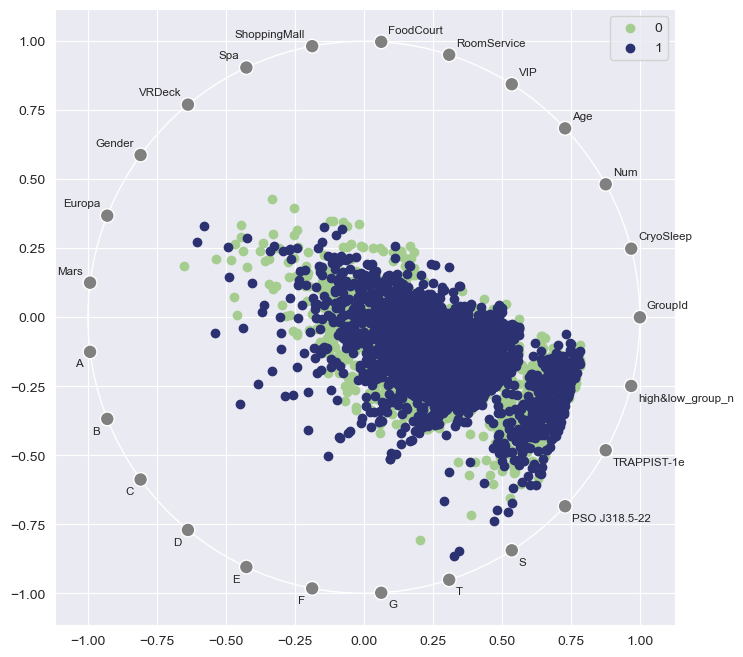

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
pd.plotting.radviz(df_dummy, 'Transported', ax=ax, colormap='crest')

In [35]:
# are classes imbalanced?
df_dummy['Transported'].value_counts()

# perfectly balanced, as all things should be...

Transported
1    4277
0    4216
Name: count, dtype: int64

In [36]:
feauters = df_dummy.drop('Transported', axis=1)
labels = df_dummy['Transported']

org_cols = feauters.columns
cols2 = ['Num', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# let's impute continous data
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(feauters[cols2])
feauters.loc[:, cols2] = imputed

# let's normalize the data
scaler = StandardScaler()
feauters = scaler.fit_transform(feauters)
feauters = pd.DataFrame(feauters, columns=org_cols)

##### 4. Building & training the model

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

In [38]:
X_train, X_test, y_train, y_test = train_test_split(feauters, labels, random_state=42)

In [39]:
for model in [DecisionTreeClassifier(), 
              LogisticRegression(), 
              SVC()]:
     
    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)
    report = classification_report(y_test, y_hat)

    print('='*40)
    print(model.__class__.__name__)
    print(report)

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1059
           1       0.75      0.76      0.76      1065

    accuracy                           0.76      2124
   macro avg       0.76      0.76      0.76      2124
weighted avg       0.76      0.76      0.76      2124

LogisticRegression
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1059
           1       0.78      0.82      0.80      1065

    accuracy                           0.79      2124
   macro avg       0.79      0.79      0.79      2124
weighted avg       0.79      0.79      0.79      2124

SVC
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1059
           1       0.80      0.81      0.80      1065

    accuracy                           0.80      2124
   macro avg       0.80      0.80      0.80      2124
weighted avg       0.80     

Learning rate set to 0.039137
0:	learn: 0.7597197	test: 0.7594728	best: 0.7594728 (0)	total: 59.5ms	remaining: 1m 52s
500:	learn: 0.8788295	test: 0.7990115	best: 0.8113674 (150)	total: 1.32s	remaining: 3.67s
1000:	learn: 0.9157851	test: 0.8064250	best: 0.8113674 (150)	total: 2.53s	remaining: 2.28s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8113673806
bestIteration = 150

Shrink model to first 151 iterations.
CatBoostClassifier
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       603
           1       0.80      0.83      0.82       611

    accuracy                           0.81      1214
   macro avg       0.81      0.81      0.81      1214
weighted avg       0.81      0.81      0.81      1214

Learning rate set to 0.039137
0:	learn: 0.7608188	test: 0.7561779	best: 0.7561779 (0)	total: 2.19ms	remaining: 4.17s
500:	learn: 0.8725100	test: 0.8088962	best: 0.8113674 (469)	total: 1.26s	remaining: 3.52s
1000:	le

Learning rate set to 0.039138
0:	learn: 0.7703297	test: 0.7617477	best: 0.7617477 (0)	total: 2.23ms	remaining: 4.24s
500:	learn: 0.8741758	test: 0.8112119	best: 0.8219291 (194)	total: 1.28s	remaining: 3.57s
1000:	learn: 0.9200549	test: 0.8128607	best: 0.8219291 (194)	total: 2.5s	remaining: 2.25s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8219291014
bestIteration = 194

Shrink model to first 195 iterations.
CatBoostClassifier
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       602
           1       0.81      0.84      0.83       611

    accuracy                           0.82      1213
   macro avg       0.82      0.82      0.82      1213
weighted avg       0.82      0.82      0.82      1213

Learning rate set to 0.039138
0:	learn: 0.7594780	test: 0.7675185	best: 0.7675185 (0)	total: 1.9ms	remaining: 3.61s
500:	learn: 0.8752747	test: 0.8186315	best: 0.8202803 (325)	total: 1.24s	remaining: 3.46s
1000:	learn

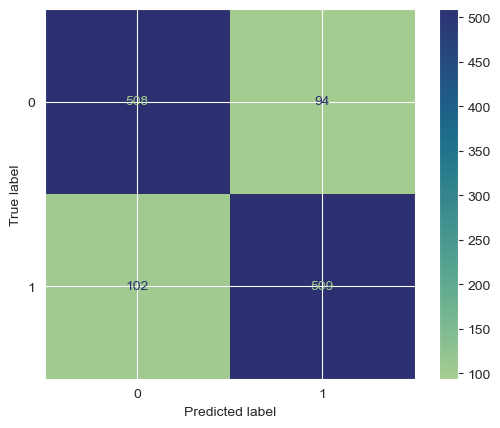

In [40]:
# not bad, let's boost it a little more with catboost

kfold = StratifiedKFold(7, shuffle=True, random_state=42)

for idx, (train_indices, test_indices) in enumerate(kfold.split(feauters, labels)):
    X_train = feauters.iloc[train_indices]
    X_test = feauters.iloc[test_indices]
    y_train = labels.iloc[train_indices]
    y_test = labels.iloc[test_indices]
    p = {
        'iterations': 1900,
        'depth': 6, 
        'early_stopping_rounds': 1000,
        'eval_metric': 'Accuracy',
        "verbose": 500
    }
    
    model = CatBoostClassifier(**p)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    y_hat = model.predict(X_test)
    report = classification_report(y_test, y_hat)

    print('='*40)
    print(model.__class__.__name__)
    print(report)

    if idx == 2:
        conf_mat = confusion_matrix(y_test, y_hat)
        disp = ConfusionMatrixDisplay(conf_mat, display_labels=model.classes_)
        display(disp.plot(cmap='crest'))

    if not os.path.exists('models'): os.mkdir('models')
    file_path = f"model_{idx}.model"
    model.save_model(os.path.join('models',file_path))

In [41]:
# it seems that the best is model_2, so we will load it from earlier saved file

loaded_model = CatBoostClassifier()
loaded_model.load_model(os.path.join('models','model_2.model'))

# samplesub = pd.read_csv('sample_submission.csv')
# test_data = pd.read_csv('test_cleaned.csv')
# test_data = test_data.iloc[:, 1:]

# y_hat = loaded_model.predict(test_data)
# answer = pd.DataFrame({'PassengerId': samplesub.PassengerId, 'Transported': list(map(lambda x: True if x==1 else False, y_hat))})
# with open('answer.csv', 'w') as f:
#     answer.to_csv(f, index=None)

##### 5. Conclusions

As we can see, CatBoost performs best with this dataset with 0.83 f-1 score.
(Kaggle score - 0.8057).

If we seek only for traditional machine learning methods, we can use glorious Supported Vector Machines (SVM) and we will end up with 0.80 f-1, which is still satisfying result.